# Database generator for pulse profiles in X-ray emitting pulsars:

    This notebook will define all the functions describing an x-ray emitting pulsar, considering a hotspot on the surface. The hotspot will be only one, and it will be located with respect to the rotation axis. The angle between the rotation inclination and the hotspot will be adressed in order to locate the hotspot in an efficient way. Then the beam pattern emission is defined, dependent on 3 parameters, and interpolate with the intrinsic angles of the hotspot in order to find which pulse profile is seen.
    
    Once all of this is done, the code will collect the data for different combination of parameters, saving the parameters and the linked pulse profile in a list of dictionaries. This list will then be converted into a dataframe with pandas and saved into a Parquet file.

    Then an example of reading the data and using them is given to the reader, in order to understand better how to handle the data.

In [60]:
import numpy as np
from scipy.interpolate import interp2d
import os
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
import time
import matplotlib.pyplot as plt

Now I imported everything I will use later on, be careful to install all that is needed for this code to run properly

## Define the physical functions of the setting

These two functions are simply used to change coordinates in the future

In [61]:
def cart2sph(x, y, z):
    xy = np.sqrt(x ** 2 + y ** 2)

    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    phi = np.arctan2(y, x)
    theta = np.arctan2(xy, z)

    return r, theta, phi


def sph2cart(r, theta, phi):
    X = r * np.sin(theta) * np.cos(phi)
    Y = r * np.sin(theta) * np.sin(phi)
    Z = r * np.cos(theta)
    return X, Y, Z

With the following function I locate the hotspot on the surface of the pulsar. There are different possible positions of the hotspot that form a circle
around the rotation axis, the *Rotation.from_rotvec* function takes care of it:

In [62]:
def hotspotXYZ(RotationInclination, RotationAzimut, MagnColatitude, npoints, shift=0):
    
    """This function defines the position of the hotspot.

        Parameters:
            ----------
            RotationInclination: how much is the rotation axis inclined in deg

            RotationAzimuth: the azimuthal angle that defines the rotation axis in deg

            MagnColatitude: Angular position of the hotspot with respect to the rotation axis point, in deg.
            E.g. if between the rotational vector and the vector from the center of the sphere and the hotspot there is an angle of 30°,
            this will be the MagneticColatitude

            npoints: The number of points where the hotspot can lay around the rotational axis, it will be the same as the dimension as the decomposition values (32)

            shift: The phase shift due to a different angle of observation of the system, will give the same pattern but shifted, in rad

        Returns:
            ----------------
            hotspot:
                position of the points where the hotspot can be around the rotation axis (list of arrays)

            """
    
    from numpy.linalg import norm
    from scipy.spatial.transform import Rotation
    ##  We first locate the rotation axis creating the point on the sphere defined by the given angles  ##

    altitude = np.deg2rad(90 - RotationInclination)  # inclination 0-90 deg, from the horizon up
    azimuth = np.deg2rad(RotationAzimut)  # 0-2*pi, around a circle on the horizon
    rotax = sph2cart(1, altitude, azimuth)  # in cartesian coordinates
    rotax = rotax / norm(rotax)  # normalized

    ## --- Location of the hotspot --- ###
    HotspotAltitude = altitude + np.deg2rad(
        MagnColatitude)  # inclination 0-90 deg, from the horizon up, defined with respect to the altitude of the rotational angle
    HotspotAzimuth = azimuth  # 0-2*pi, around a circle on the horizon

    hotspot = sph2cart(1, HotspotAltitude, HotspotAzimuth)  # Locating the hotspot in cartesian coordinates
    hotspot = hotspot / norm(hotspot)  # Normalization of the vector to fit in the sphere of radius 1

    ## --- Rotation of the hotspot around the rotation axis --- ###
    phirot = np.linspace(0 + shift, 2 * np.pi + shift,
                         npoints).tolist()  # We create an array of equispaced angles based on the defined shift
    rot = [Rotation.from_rotvec(x * rotax) for x in
           phirot]  # Rotation.from_rotvec defines the parameters for a rotation around a point

    hotspot = [x.apply(hotspot) for x in
               rot]  # Creates different possible hotspots around the rotation axis, applying the rotation with x.apply(),
    # using hotspot we have the rotation based on the MagnColatitude, all the vectors defining this rotation will have a MagnColatitude angle with respect to the rotation axis
    return hotspot

This function is simply used to take into account the gravitational light bending due to general relativity, in order to correlate the observed angles with the intrinsic ones:

In [63]:
def GravitationalLightBending(psi):
    """ Defines all the parameters needed for light bending using general relativity, and then returns the angle the observer sees

    Parameters:
        ------------
    psi: angle observed due to light bending (float)

    Returns:
        ------------
        alpha: actual angle of emission (float)

    Notes:
        See Beloborodov 2002 Equation 1 for futher information

        """
    G = 6.67e-8  # cm3 g−1 s−2
    M = 1.98847e33  # g
    mNS = 1.4  # in solar masses (M)
    lsc = 2.99792458e10  # cm/s
    rg = 2 * G * mNS * M / lsc ** 2 * 1e-5  # km
    r = 3 * rg  # 3*rg = 12; 10 # km   # 2/0.19 rg = 43.5 km

    alpha = np.arccos(
        1 - (1 - np.cos(psi)) * (1 - rg / r))  # Beloborodov 2002 Equation 1; psi in B02 = beta for me; alpha = alpha

    return alpha



With the functions and the position of the hotspot defined before we are able to find the angles that describe the hotspot. The *GravitationalLightBending* is applied in order to take into account general relativity:

In [64]:
def intrinsicAngles(hotspotLoc):
    """Transforms the observed angles, defined with the function hotspotXYZ, into
     the intrinsic angles, taking into account the gravitational light bending


     Parameters:
        -----------
        hotspotLoc: Location of the hotspot, list of arrays defining the angles of the positions of the hotspot around the rotation axis (list of arrays)

     Returns:
        ------------
        hotspotTheta: list of the possible observed azimuthal angles of the hotspot (list)

        hotspotPhi: list of the possible observed inclination angles of the hotspot (list)

        intrinsicTheta: possible intrinsic azimuthal angles of the hotspot, aster taking into account gravitational light bending (list)

        intrinsicPhi: possible intrinsic inclination angles of the hotspot, aster taking into account gravitational light bending (list)

     """
    hotspotTheta = [np.pi / 2 - cart2sph(*loc)[1] for loc in
                    hotspotLoc]  # Get the azimuthal angles from the location of the hotspots
    hotspotPhi = [cart2sph(*loc)[2] for loc in
                  hotspotLoc]  # Get the inclination angles from the location of the hotspots

    intrinsicTheta = GravitationalLightBending(hotspotTheta)  # Transforming theta with the gravitational bending
    intrinsicTheta = np.nan_to_num(intrinsicTheta, nan=np.pi)
    intrinsicTheta = np.where(np.array(hotspotTheta) < 0, -intrinsicTheta,
                              intrinsicTheta)  # need this because of geometrical symmetries that are not part of the equation in GravitationalLightBending

    intrinsicPhi = GravitationalLightBending(hotspotPhi)  # Transform phi with the gravitational light bending
    intrinsicPhi = np.nan_to_num(intrinsicPhi, nan=np.pi)
    intrinsicPhi = np.where(np.array(hotspotPhi) < 0, -intrinsicPhi,
                            intrinsicPhi)  # need this because of geometrical symmetries that are not part of the equation in GravitationalLightBending

    return hotspotTheta, hotspotPhi, intrinsicTheta, intrinsicPhi

The function *defBeampattern* is very important because it defines the beam pattern, that is the beam emitted from the hotspot. This is defined by
three parameters. An **inclination angle**, an **azimuthal angle** (both defined with respect to the normal to the surface of the hotspot),
and the **power** of the beam, that describes the "peakiness":

In [65]:
def defBeampattern(irange, arange, grid1, grid2, param1, param2, param3, param4, param5):
    """Uses the parametrization of the beam pattern in order to place it on the grid defined by grid1 and grid2,
     irange and arange are the range of the angles that are used to define the grids that we mesh together afterward to create the whole grid to plot the beampattern on.
     This function also includes the asymmetry of the inclination and the azimuthal angles of the beam emission.
     these angles are defined with respect to the normal to the surface of the hotspot.

     Parameters:
        -------------
        irange: range of the possible inclination angles (from 0 to pi/2), with respect to the normal of the hotspot (list)

        arange: range of the possible azimuthal angles (from -pi/2 to pi/2), with respect to the y-axis (list)

        grid1: X result from the meshgrid of irange and arange (list of arrays)

        grid2: Y result from the meshgrid of irange and arange (list of arrays)

        param1, param2: define the shifting of the cosine functions in the equation of beampattern. (float)

        param3: define the exponent of the equation beampattern that allows to adjust the width or “peakiness” of the beam pattern (float)

        param4, param5: Used to multiply the cosines of the irange and arange angles to introduce more asymmetry (float)

    Returns:
        ----------------
        beampattern: the pattern of the beam that is emitted from the pole of the pulsar, containing also the asymmetries (2D numpy array)

    References:
        -----
        fig 7.12, pag. 134 of Saathof, 2023
     """

    beampattern = (np.cos(grid2 + param1) * np.cos(grid1 + param2)) ** int(param3)
    # irange_asym = np.array(np.cos(irange) * param4)
    # arange_asym = np.array(np.cos(arange) * param5)
    # beampattern = beampattern.T
    # beampattern += irange_asym  # adding the asymmetries to the pattern calculated before
    # beampattern = beampattern.T
    # beampattern += arange_asym

    beampattern = np.abs(beampattern)
    beampattern /= np.max(beampattern)
    beampattern = np.where(grid1 > np.pi / 2, 0, beampattern)
    beampattern = np.where(grid2 > np.pi / 2, 0, beampattern)
    beampattern = np.where(grid1 < -np.pi / 2, 0, beampattern)
    beampattern = np.where(grid2 < -np.pi / 2, 0, beampattern)
    return beampattern


## Do the physics

All the functions defined before are used here, that gives an interpolation between the beampattern and the intrinsic angle of the hotspot, 
in order to get back the parameters and, most importantly the resulting **pulse profile**:


In [66]:
def f_parametrized(RotationInclination, RotationAzimuth, MagnColatitude, param1, param2, param3, param4, param5, shift):
    """Combines all the functions defined before:

    Parameters:
        -----------
        RotationInclination: angle of inclination of the rotation axis

        RotationAzimuth: azimuth angle of the rotation axis

        MagnColatitude: relative angle between the hotspot vector and the rotation axis

        param1, param2, param3, param4, param5: see the function "defBeamPattern"

        shift: phase shift of the pulse profile

    Returns:
        ---------------
        irange: range of the inclination angle of the beam emission

        arange: range of the azimuth angle of the beam emission

        grid1, grid2: grid defined by irange and arange, from meshgrid

        hotspotLoc: location of the hotspot, calculated with the function "hotspotXYZ"

        decomposition: the decomposition of the pulse profile defined by the function "decompositions"

        hotspotTheta: list of the possible observed azimuthal angles of the hotspot (list)

        hotspotPhi: list of the possible observed inclination angles of the hotspot (list)

        intrinsicTheta: possible intrinsic azimuthal angles of the hotspot, aster taking into account gravitational light bending (list)

        intrinsicPhi: possible intrinsic inclination angles of the hotspot, aster taking into account gravitational light bending (list)

        pattern: the pattern defined by the equations of the beam in "defBeamPattern" (2D numpy array)

        hotspotPattern: pattern obtained interpolating the function of the beamPattern with the angles that define the hotspot (list)
        """

    irange = np.linspace(-np.pi / 2, np.pi / 2, 32)
    arange = np.linspace(-np.pi / 2, np.pi / 2, 32)
    grid1, grid2 = np.meshgrid(irange, arange)
    npoints = 32

    hotspotLoc = hotspotXYZ(RotationInclination, RotationAzimuth, MagnColatitude, npoints, shift)

    hotspotTheta, hotspotPhi, intrinsicTheta, intrinsicPhi = intrinsicAngles(hotspotLoc)

    pattern = defBeampattern(irange, arange, grid1, grid2, param1, param2, param3, param4, param5)
    patternSpline = interp2d(irange, arange, pattern,
                             kind='cubic')  # gives a function that can interpolate the grid (x y axis) with the beam pattern (z axis)

    hotspotPattern = [patternSpline(intrinsicTheta[i], intrinsicPhi[i]) for i in
                      range(len(intrinsicPhi))]  # Evaluate the interpolating function at the angles of the hotspot
    hotspotPattern = np.concatenate(hotspotPattern).ravel().tolist()

    return irange, arange, grid1, grid2, hotspotLoc, \
        hotspotTheta, hotspotPhi, intrinsicTheta, intrinsicPhi, \
        pattern, hotspotPattern, param1, param2, param3, param4, param5

## Data creation

First of all I want to describe the ranges of the parameters, and to do so I create a function which uses a *linspace*
for each parameter of the given length:

In [67]:
def ranges(i):
    """This function defines the ranges of variation of the parameters in order to create the data

    Parameters:
        ----------
        i: the number of iterations for each parameter (float)

    Returns:
        ----------
        A list of len = i for each of the 7 parameters

        """
    rot_i = np.linspace(-90, 90, i + 3) # More important, I added 3 iterations for now, there can be more
    rot_a = np.linspace(-150, 180, i, endpoint=False) #Not super interested if the hotspot is behind the star, exclude +-180
    magnc = np.linspace(0, 90, i)
    shift = np.linspace(-np.pi, np.pi, i, endpoint=False) #Set some endpoint= False because I think they would lead to the same result
    p1 = np.linspace(-np.pi, np.pi, i, endpoint=False)
    p2 = np.linspace(-np.pi, np.pi, i, endpoint=False)
    p3 = np.linspace(0, 20, 4)  # Less important, let us limit to 4 interactions

    # init_p4 = np.linspace(0, 1, 5) #These are asymmetry parameters, ignore for now
    # p5 = np.linspace(0, 1, 5)

    return rot_i, rot_a, magnc, shift, p1, p2, p3


Now let's generate **all the possible combinations** from the ranges I just defined:

In [68]:
def generate_combinations(rot_i, rot_a, magnc, shift, p1, p2, p3):
    """This list comprehension simply generates all the possible combinations from the
    given lists of data, in order to use it in the function without for cycles

    Parameters:
        ---------
        rot_i, rot_a, magnc, shift, p1, p2, p3: The 7 ranges of parameters that we need to iterate with (list)

    Returns:
        ----------
        combo: list containing all the possible combinations of parameters
        """
    combo = [(rot_i[q], rot_a[t], magnc[u], p1[i], p2[j], p3[k], shift[v])
            for q in range(len(rot_i))
            for t in range(len(rot_a))
            for u in range(len(magnc))
            for v in range(len(shift))
            for i in range(len(p1))
            for j in range(len(p2))
            for k in range(len(p3))]
    return combo

This returned a list that containes all the possible combinations of the parameters.

## ProcessPoolExecutor parallelization (use it alternatively to the "Linear for cycle process")

 The next step is to iterate over all the possible values
of this list and to pass the values to the function describing the physical processes, in order to obtain the corresponding values of the hotspot and the pulse profile corresponding to the different combinations of parameters. This goal will be achieved with the function iterations, where the only input parameter will be the combination just generated.

In [34]:
def iterations(combo):
    """With this function I iterate the combined ranges in the function that defines the final dataset.

    Parameters:
        ---------
        The list of all the possible data combinations

    Returns:
        -----------
        The list of dictionaries containing the data (parameters and hotspot pattern) of the function defining the code

    Notes:
        This function is used in this way and not with the for cycles within it because it was the only way I could figure
        how to run the processes in parallel with ProcessPoolExecutor
        """

    rot_i, rot_a, magnc, p1, p2, p3, shift = combo #assign the values to the parameters
    data = []  # creates the listy of future data
    # Now that we fixed the values iterating, let's use the function to calculate the physical data

    irange, arange, grid1, grid2, hotspotLoc, hotspotTheta, hotspotPhi, intrinsicTheta, intrinsicPhi, beampattern, hotspotPattern, \
        param1, param2, param3, param4, param5 = \
        f_parametrized(rot_i, rot_a, magnc, p1, p2, p3, 0, 0, shift)

    # Create a dictionary to append to the list for every interaction

    data_to_save = {
        # 'intrinsic theta': intrinsicTheta,
        # 'intrinsic phi': intrinsicPhi,
        'param1': param1,
        'param2': param2,
        'param3': param3,
        # 'param4': params['param4'],
        # 'param5': params['param5'],
        'hotspot pattern': hotspotPattern,
        'rotation inclination': rot_i,
        'rotation azimuth': rot_a,
        'magnetic colatitude': magnc,
        'shift': shift,
    }

    # Append the dictionary to the list of data

    data.append(data_to_save)

    # Put a progress bar if needed, not sure how to implement here

    return data

This returns a list of dictionaries that contain the data we are interested in saving.

One dictionary in the list looks like this:


#### Put all together

The goal now is to do everything I described before, running the different processes in parallel with ProcessPoolExecutor. First of all let us choose a length for the parameters range and generate the ranges

In [35]:
if __name__ == "__main__": #This is apparently needed otherwise the code crashes

    # Define the number of iterations for each parameter
    length = 4  # Change this as needed

    rot_i, rot_a, magnc, shift, p1, p2, p3 = ranges(length) #Create the ranges of the parameters


The next step is to generate all the combibations from the chosen ranges, calling the function described beforehand

In [36]:
 # Generate all combinations of the parameters
combo = list(generate_combinations(rot_i, rot_a, magnc, shift, p1, p2, p3))

Now let's proceed with calling the main function "iterations" (that contains the physical funnction and parameters). To do so I will use a parallelization of the processes, utilizing the function ProcessPoolExecutor, that takes as a parameter the number of processors one wants to use to run the code.

In [22]:
with ProcessPoolExecutor() as executor:
    #Use the parallelization to compute the data
        final = executor.map(iterations, combo)

This executes different processes in parallel and therefore improves the time taken by the code to run. This might have some problems, so I will also describe the "linear" process that will take more time but it is easier to run since it doesn't involve function with multiprocessing. 

This returns an object which is composed of lists where each list contains one dictionary, in order to get a cleaner database, with only one list containing all the dictionaries, we have to proceed with a little manipulation of the data, in order to proceed saving them

In [24]:
data = []
for element in final:
    data.append(element[0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

## Linear for cycle process (Use as an alternative for "ProcessPoolExecutor parallelization")

This method is simpler conceptually because it simply iterates with for cycle over all the possible combinations and generates the data from there. 

<b>Use a low number in ranges to try (4 max) because it scales exponentially

In [69]:
data = []  # creates the listy of future data
(rot_i, rot_a, magnc, p1, p2, p3, shift) = ranges(4)
combo = generate_combinations(rot_i, rot_a, magnc, p1, p2, p3, shift)

Now that I have generated all the data combinations, let's iterate over those, calling the function describing the physical process,  *f_parametrized*, for every different combination of parameters. 
In this *for cycle* for every iteration the results are saved in a dictionary that is appended at the empty list created earlier, in order to have the list of dictionaries at the end of the process:

In [70]:
for element in combo:
    
    rot_i, rot_a, magnc, p1, p2, p3, shift = element #assign the values to the parameters
    
    # Now that we fixed the values iterating, let's use the function to calculate the physical data

    irange, arange, grid1, grid2, hotspotLoc, hotspotTheta, hotspotPhi, intrinsicTheta, intrinsicPhi, beampattern, hotspotPattern, \
        param1, param2, param3, param4, param5 = \
        f_parametrized(rot_i, rot_a, magnc, p1, p2, p3, 0, 0, shift)

    # Create a dictionary to append to the list for every interaction

    data_to_save = {
        # 'intrinsic theta': intrinsicTheta,
        # 'intrinsic phi': intrinsicPhi,
        'param1': param1,
        'param2': param2,
        'param3': param3,
        # 'param4': params['param4'],
        # 'param5': params['param5'],
        'hotspot pattern': hotspotPattern,
        'rotation inclination': rot_i,
        'rotation azimuth': rot_a,
        'magnetic colatitude': magnc,
        'shift': shift,
    }

    # Append the dictionary to the list of data

    data.append(data_to_save)

C:\Users\Utente\AppData\Local\Temp\ipykernel_9444\2525079040.py:51: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  patternSpline = interp2d(irange, arange, pattern,
C:\Users\Utente\AppData\Local\Temp\ipykernel_9444\2525079040.py:54: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for

## Saving data in a parquet file

Now either path you chose in order to generate data, you will have a **list of dictionaries**. 
Each dictionary should look like this (this are random data from my database):

{'param1': 1.8849555921538759, 'param2': 0.6283185307179586, 'param3': 6.666666666666667, 'hotspot pattern': [ 1.88177966e-01,  2.23304447e-01,  2.58136002e-01,  2.83790161e-01,
        2.89524631e-01,  2.66984723e-01,  2.15774666e-01,  1.46896294e-01,
        7.94433174e-02,  3.09385557e-02,  7.15113550e-03,  6.04311015e-04,
        2.10630832e-06, -3.01634917e-07,  4.69047858e-04,  1.19985999e-02,
        7.83525164e-02,  2.46678301e-01,  4.88061390e-01,  7.09863153e-01,
        7.12928652e-01,  6.71364382e-01,  6.11643015e-01,  5.38945897e-01,
        4.60805567e-01,  3.84938327e-01,  3.17476421e-01,  2.62035695e-01,
        2.19993452e-01,  1.91048215e-01,  1.74265599e-01,  1.8817796e-01]), 'rotation inclination': -64.28571428571428, 'rotation azimuth': 114.0, 'magnetic colatitude': 67.5, 'shift': -3.141592653589793}


You can compare it with an example from this code:

In [71]:
print(data[3]) #Choose a random number

{'param1': -3.141592653589793, 'param2': -3.141592653589793, 'param3': 20.0, 'hotspot pattern': [4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28, 4.2530517769973685e-28], 'rotation inclination': -90.0, 'rotation azimuth': -150.0, 'magnetic colatitude': 0.0, 'shift': -3.141592653589793}


One can notice how all the parameters are float, ecxept for the hotspot pattern that has 32 entries, and it is the pulse profile we are interested in.

Now we want to save it in a correct way that will result easy to read back and to use. 
To do so I chose to use a **parquet file**, that is both complete for the dataset I have and at the same time rather simple. I proceed creating a dataframe with pandas:

In [72]:
df = pd.DataFrame(data)

Now let's define a file path to save the data and dump the data into the file, making sure the **engine = "pyarrow"** is specified when saving the data in order to achieve a correct encoding:

In [73]:
 # Define the filepath
file_name = f'bigdata'
folder_path = "C:\\Users\\Utente\\Desktop"
filepath = os.path.join(folder_path, file_name) #Can also just write the filepath here

#This should dump everything and create the parquet file with the chosen path
df.to_parquet(file_path, engine='pyarrow', index=False) 

So we have created the database as a parquet file!

## How to read the data

Now the goal is **to read the data and try to use them somehow.** The following part of the code will read all the data back and use them, to give an overview on how to handle the data processing.

This first function I define prints the keys of the dictionary. 
It is helpful when reading the data to know which are the keys and what do they mean. Knowing the keys and what do they represent is fundamental for someone who just wants to use the file and was not involved in the creation process of the database:

In [74]:
def printKeys(data_dict):
    """
    Prints the keys of the dictionary used in the project

    Parameters:
        ----------
        data_dict: List of dictionaries, it should be read (or obtained) from the simulation data

    Returns:
        ---------
        The keys of the dictionary used

    Notes:
        ----------
        This displays the keys but the data_dict that we have is a list of dictionaries,
        so keep it in mind when reading at next steps
    """
    keys = data_dict[1].keys()
    descriptions = [
        "is the \"azimuthal\" parameter of the beam pattern",
        "is the \"inclination\" parameter of the beam pattern",
        "is the power parameter of the beam pattern",
        "is the pulse profile computed with the parameters",
        "is the angle of inclination of the rotation axis",
        "is the azimuthal angle of the rotation axis",
        "is the magnetic colatitude, describes the angle between the possible hotspots and the rotation axis",
        "is the position of the hotspot around the rotation axis",

    ]
    i = 0
    for key in data_dict[1]:

        print("%s: %s\n" %(key, descriptions[i]))
        i += 1

The following function takes as a parameter the file we created (or another parquet file with the exact type of data encoded into it) and reads it in a list of dictionaries that can be used in the following.  It also calls the function to print the keys:

In [75]:
def readParquetToDict(filepath):
    """This function reads the parquet file where the data are stored and transforms the data in order to have a dictionary

    Parameters:
        -----------
        filepath (string) : the path of the file that we want to read the data from

    Returns:
        ---------
        A list of the dictionaries of the data (list[dict])

    Notes:
        --------

        Install pyarrow to use this
        Install and import pandas as pd

        """
    file_path = str(filepath)
    
    loaded_data = pd.read_parquet(file_path, engine='pyarrow')
    
    data_dict = loaded_data.to_dict(orient="records")
    
    printKeys(data_dict)
    
    return data_dict

Let's now use these reading functions to have a list of dictionaries (that should be the same as we created before in this same file

In [76]:
loaded_data = readParquetToDict(filepath)

param1: is the "azimuthal" parameter of the beam pattern

param2: is the "inclination" parameter of the beam pattern

param3: is the power parameter of the beam pattern

hotspot pattern: is the pulse profile computed with the parameters

rotation inclination: is the angle of inclination of the rotation axis

rotation azimuth: is the azimuthal angle of the rotation axis

magnetic colatitude: is the magnetic colatitude, describes the angle between the possible hotspots and the rotation axis

shift: is the position of the hotspot around the rotation axis



*If you ran all the cells correctly, just above this line there should be the keys of the dictionary with a brief description of each*

## Example of usage

Now I would like to try to use these data after having read them. I believe this is very useful because one can understand how the data are stored and how they can be extrapolated. 

The example will be a fitting to experimental data, with the program choosing the best fitting simulated parameters, printing them and plotting the graph containing both the experimental data and the best fitting simulated pulse profile.

The following two functions were also described at the beginning and they are useful only as an **experimental example** to use as a comparison for our simulation data:

In [77]:
def normalise_weights(w1, w2):

    wsum = w1 + w2
    w1 = w1 / wsum
    w2 = w2 / wsum
    wsum = wsum / np.mean(wsum)
    return w1, w2, wsum


def decompositions():
    """This function creates the decomposition of the total pulse profile into two different pulse profiles coming
    from the different poles from the experimental data

    Return
        -----------
        d1, d2: The two experimental curves that define the decomposition in the two different contributing poles (numpy arrays)"""
    d1 = np.array([2.089433657753390321e+02,2.194589299387001233e+02,2.242701956130024143e+02,2.215828113982570358e+02,2.119044080603044904e+02,1.896290164200222534e+02,1.699201994046265440e+02,1.256523129323831256e+02,8.503688265750899689e+01,7.872871603812254193e+01,6.991923027381139377e+01,5.683178911921619658e+01,3.124156755276437281e+01,7.269036823844857054e+01,6.021225567409459956e+01,3.283549153829007122e-05,2.070746335489954859e+01,2.039204294346190522e+02,4.840049429063090543e+02,7.172415178717548088e+02,8.874827811973464122e+02,9.764660867645188773e+02,9.541305245679710652e+02,8.215813339957139760e+02,6.190850039923557233e+02,4.598887253861233262e+02,3.712954485901983048e+02,3.156898180851563325e+02,2.666241611172789021e+02,2.256346741358247527e+02,2.103769883639451166e+02,2.078976085285444526e+02])
    d2 = np.array([1.706203983036242562e+02,1.627295767828694579e+02,1.508354117504467524e+02,1.387866932644533904e+02,1.222486136182712357e+02,1.134912451761991292e+02,9.134073071527171805e+01,8.393452247999425708e+01,1.066817197404563586e+02,1.153710780759624868e+02,1.233759737954631532e+02,1.483167515129746903e+02,2.492913136389517490e+02,3.399179640856401079e+02,4.636740226352187051e+02,6.800307289423939210e+02,8.913740432455606424e+02,9.093974220853033330e+02,7.202968616231810302e+02,5.014408728270462916e+02,2.981560101312231836e+02,1.266512076523395081e+02,2.776344418581356877e+01,3.598816179894583911e+00,5.163147899177897671e+01,1.027343217254183969e+02,1.227055202846957513e+02,1.252671880914211329e+02,1.319053895669890153e+02,1.488350485237368162e+02,1.574525502093866010e+02,1.655530999612218181e+02])
    d1, d2, dpp = normalise_weights(d1, d2) #All different normalisations
    d1 *= dpp
    d1 /= np.max(dpp)
    d2 *= dpp
    d2 /= np.max(dpp)
    return d1, d2

Define a very high number as summa and get the experimental data to compare to

In [79]:
summa = 100000000
d1, d2 = decompositions()

The comparison is now done with a naive *for cycle* that compares every hotspot pattern occurence in the data we simulated and read back with the experimental d1 (or d2, it works just as well). It performs a subtraction between each point and sum all of the results. The lower the total sum of the differences and the best fitting will be the simulated dictionary taken into account. The best of all fitting is saved as a list index.

In [80]:
for i in range(len(loaded_data)):
    diff = d1 - loaded_data[i]["hotspot pattern"]
    somma = np.sum(np.abs(diff))
    if np.abs(somma) < np.abs(summa):
        summa = somma
        ok = i

The important thing here is not the fitting process itself (I am sure there are way better methods) but it is important to note how to iterate on the data we have. The index i represents the index of the list, and for every instance in the list we extrapolate the hotspot pattern using a dictionary indexing.

Now we have a good fitting, let's print the parameters that we found to be the fitting ones:

In [81]:
fit = loaded_data[ok]
print(fit)

{'param1': 0.0, 'param2': -3.141592653589793, 'param3': 6.666666666666667, 'hotspot pattern': array([ 5.11139778e-07,  5.14039026e-99,  6.53067621e-99,  9.03755773e-99,
        1.28160842e-98, -1.01884776e-21, -5.49023213e-22,  9.03039382e-22,
        8.40281939e-23, -2.15763705e-21, -1.03129026e-21,  3.21937683e-06,
        5.29200071e-05,  8.20201556e-04,  5.56714234e-03,  2.34144622e-02,
        7.07298643e-02,  1.65877701e-01,  3.16017629e-01,  5.03144100e-01,
        6.81893230e-01,  7.95220838e-01,  8.01894743e-01,  6.98226972e-01,
        5.20480511e-01,  3.26008668e-01,  1.65640759e-01,  6.39431353e-02,
        1.65206346e-02,  2.18022168e-03,  7.35891158e-05,  5.11139778e-07]), 'rotation inclination': 60.0, 'rotation azimuth': -67.5, 'magnetic colatitude': 60.0, 'shift': -3.141592653589793}


From the fitting dictionary we want to extrapolate the parameters, and to do so we just need the dictionary indexing, since the list indexing has been fixed with the fitting process (**ok** is the index we are interested into):

In [82]:
param1 = fit["param1"]
param2 = fit["param2"]
param3 = fit["param3"]
rot_i = fit["rotation inclination"]
rot_a = fit["rotation azimuth"]
magnc = fit["magnetic colatitude"]
shift = fit["shift"]

I believe that this example is useful on how to read and use the data, strongly highlighting the fact that in order to handle the data one has to deal with a list of dictionaries, and having a clear vision of the keys is fundamental in order to utilize the values.

### Plotting and showing the fit

This last point only shows the results as a fit, checking that the fit works with the given experimental data.

Let's create a linspaced x axis and plot both the fit and the data. I also want to print on the plot the parameters we have extrapolated before from the fitting dictionary, with a small description

Text(0.05, 0.95, '$param1$: 0.000000\n$param2$: -3.141593\n$param3:6.666667$\nrotation inclination: 60.000000\nrotation azimuth: -67.500000\n$shift:-3.141593$')

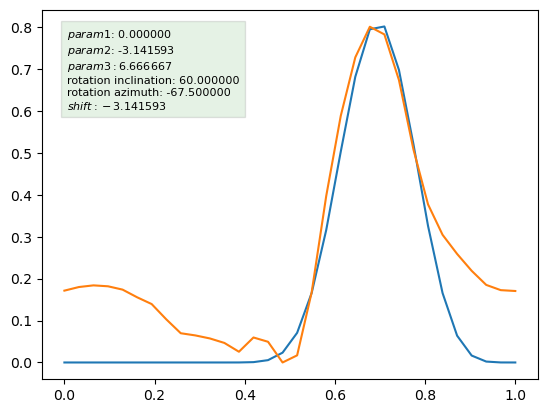

In [83]:
x = np.linspace(0, 1, 32)
plt.plot(x, fit["hotspot pattern"])
plt.plot(x, d1)
textstr = '\n'.join((
        r'$param1$: %f' % (fit["param1"]),
        r'$param2$: %f' % (fit["param2"]), r'$param3:%f$' % (fit["param3"]),
        r'rotation inclination: %f' % (fit["rotation inclination"]),
        r'rotation azimuth: %f' % (fit["rotation azimuth"]), r'$shift:%f$' % (fit["shift"])))

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
             fontsize=8, verticalalignment='top', bbox=dict(facecolor='green', alpha=0.1))

And finally show everything. The result I obtained, with 100000 data, is:

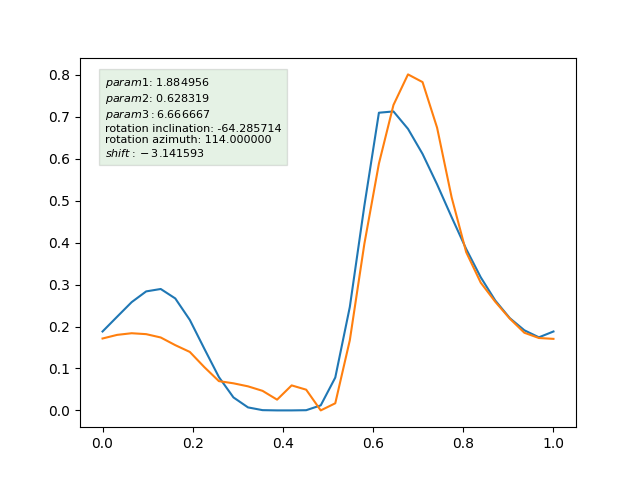